In [48]:
import numpy as np
import pandas as pd
import xgboost as xgb

import bisect
import functools as ft
import logging
import random
import typing as t
import seaborn as sns 
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import math
import datetime
from ignite.contrib.metrics.regression import MeanAbsoluteRelativeError

In [2]:
data= pd.read_csv("data/train")

In [3]:
data.columns

Index(['dataset_type', 'demand', 'departure_date',
       'destination_current_public_holiday',
       'destination_current_school_holiday',
       'destination_days_to_next_public_holiday',
       'destination_days_to_next_school_holiday', 'destination_station_name',
       'od_destination_time', 'od_number_of_similar_12_hours',
       'od_number_of_similar_2_hours', 'od_number_of_similar_4_hours',
       'od_origin_month', 'od_origin_time', 'od_origin_week',
       'od_origin_weekday', 'od_origin_year', 'od_travel_time_minutes',
       'origin_current_public_holiday', 'origin_current_school_holiday',
       'origin_days_to_next_public_holiday',
       'origin_days_to_next_school_holiday', 'origin_station_name', 'price',
       'sale_date', 'sale_day', 'sale_day_x', 'sale_month', 'sale_week',
       'sale_weekday', 'sale_year'],
      dtype='object')

In [24]:
data.head()

,dataset_type,demand,departure_date,destination_current_public_holiday,destination_current_school_holiday,destination_days_to_next_public_holiday,destination_days_to_next_school_holiday,destination_station_name,od_destination_time,od_number_of_similar_12_hours,...,sale_date,sale_day,sale_day_x,sale_month,sale_week,sale_weekday,sale_year,trip_id,trip_or_dest,tripday_idt
0,training,1,2019-03-01,0,1,52,-13,ag,1088,5,...,2018-12-02,2,-89,12,6,6,2018,2019-03-01922cpeag,cpeag,2019-03-01cpeag
1,training,6,2019-03-01,0,1,52,-13,ag,1088,5,...,2018-12-03,3,-88,12,0,0,2018,2019-03-01922cpeag,cpeag,2019-03-01cpeag
2,training,5,2019-03-01,0,1,52,-13,ag,1088,5,...,2018-12-04,4,-87,12,1,1,2018,2019-03-01922cpeag,cpeag,2019-03-01cpeag
3,training,0,2019-03-01,0,1,52,-13,ag,1088,5,...,2018-12-05,5,-86,12,2,2,2018,2019-03-01922cpeag,cpeag,2019-03-01cpeag
4,training,0,2019-03-01,0,1,52,-13,ag,1088,5,...,2018-12-06,6,-85,12,3,3,2018,2019-03-01922cpeag,cpeag,2019-03-01cpeag


## Data Analysis

In [47]:
data.describe()

,demand,destination_current_public_holiday,destination_current_school_holiday,destination_days_to_next_public_holiday,destination_days_to_next_school_holiday,od_destination_time,od_number_of_similar_12_hours,od_number_of_similar_2_hours,od_number_of_similar_4_hours,od_origin_month,...,origin_current_school_holiday,origin_days_to_next_public_holiday,origin_days_to_next_school_holiday,price,sale_day,sale_day_x,sale_month,sale_week,sale_weekday,sale_year
count,632841.000000,632841.0,632841.000000,632841.000000,632841.000000,632841.000000,632841.000000,632841.00000,632841.000000,632841.000000,...,632841.000000,632841.000000,632841.000000,632841.000000,632841.000000,632841.000000,632841.000000,632841.000000,632841.000000,632841.000000
mean,3.000149,0.0,0.362070,33.468421,7.209680,917.638889,6.013457,1.42268,2.577630,6.841843,...,0.380696,33.468421,7.026528,24.369688,15.836412,-43.161835,6.331560,3.022827,3.022827,2019.442271
std,7.256572,0.0,0.480599,20.902826,28.727468,255.245208,2.383453,1.35439,1.413168,2.656572,...,0.485558,20.902826,28.681919,16.868624,8.785942,25.268251,2.828876,2.008861,2.008861,0.524664
min,0.000000,0.0,0.000000,0.000000,-58.000000,399.000000,-1.000000,-1.00000,-1.000000,2.000000,...,0.000000,0.000000,-58.000000,11.650000,1.000000,-89.000000,1.000000,0.000000,0.000000,2018.000000
25%,0.000000,0.0,0.000000,16.000000,-12.000000,698.000000,5.000000,0.00000,2.000000,5.000000,...,0.000000,16.000000,-12.000000,11.650000,8.000000,-65.000000,5.000000,1.000000,1.000000,2019.000000
50%,0.000000,0.0,0.000000,32.000000,11.000000,964.000000,6.000000,1.00000,2.000000,7.000000,...,0.000000,32.000000,11.000000,20.650000,16.000000,-42.000000,6.000000,3.000000,3.000000,2019.000000
75%,3.000000,0.0,1.000000,50.000000,31.000000,1088.000000,7.000000,2.00000,4.000000,9.000000,...,1.000000,50.000000,30.000000,29.650000,23.000000,-21.000000,8.000000,5.000000,5.000000,2020.000000
max,192.000000,0.0,1.000000,77.000000,74.000000,1370.000000,10.000000,4.00000,7.000000,11.000000,...,1.000000,77.000000,74.000000,116.650000,31.000000,-1.000000,12.000000,6.000000,6.000000,2020.000000


We will look at the distributions of the different features in order to check that we have no outlier and manage the missing values if there are any.

### Price

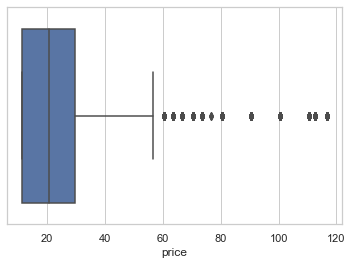

In [36]:
ax=sns.boxplot(x=data['price'])

<AxesSubplot:>

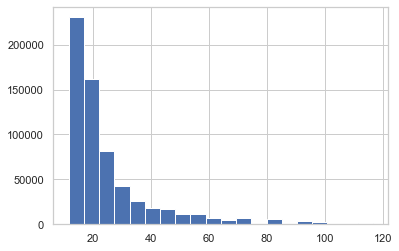

In [44]:
data.price.hist(bins=20)

### Demand

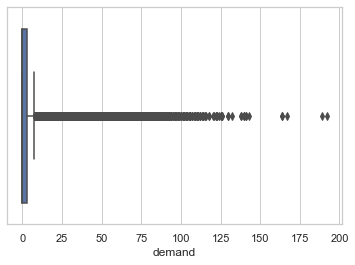

In [30]:
ax=sns.boxplot(x=data['demand'])

<AxesSubplot:>

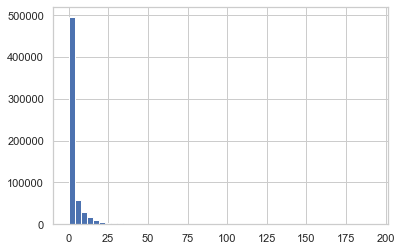

In [46]:
data.demand.hist(bins=50)

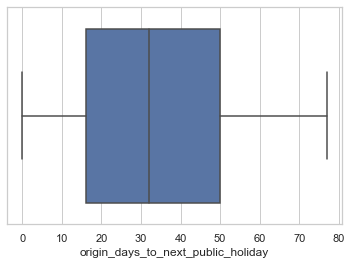

In [58]:
ax=sns.boxplot(x=data['origin_days_to_next_public_holiday'])

<AxesSubplot:>

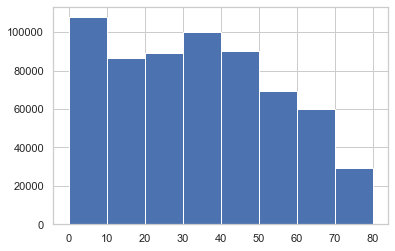

In [76]:
data.origin_days_to_next_public_holiday.hist(bins=[ 0, 10, 20, 30, 40, 50, 60, 70, 80])

<AxesSubplot:>

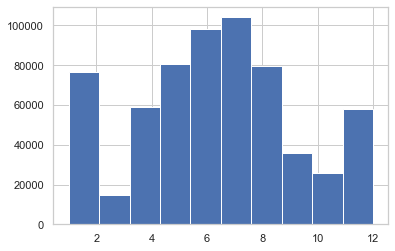

In [99]:
data.sale_month.hist()

<AxesSubplot:>

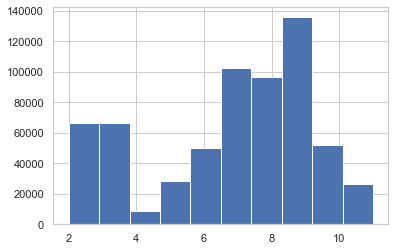

In [100]:
data.od_origin_month.hist()

<AxesSubplot:>

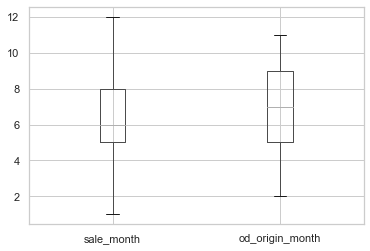

In [103]:
data.boxplot(column=['sale_month','od_origin_month'])

In [119]:
len(data.od_origin_week.unique())

44

In [131]:
data.od_origin_week.unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48,  5,  6,  7,  8])

We notice that we have no information on the trains leaving during the weeks

In [114]:
# Add column od_origin_day
data['od_origin_day'] = pd.DatetimeIndex(data['departure_date']).day

In [115]:
#Just a test to check that the od_origin_week column is correct
or_week= [
            datetime.date(year, month, day).isocalendar()[1]
            for year,month, day in zip(
                data.od_origin_year,data.od_origin_month, data.od_origin_day
            )
        ]

<AxesSubplot:>

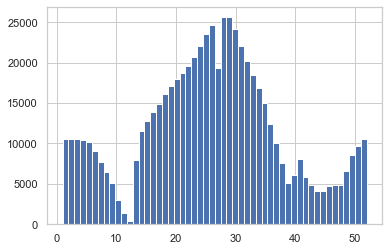

In [108]:
data.sale_week.hist(bins=52)

<AxesSubplot:>

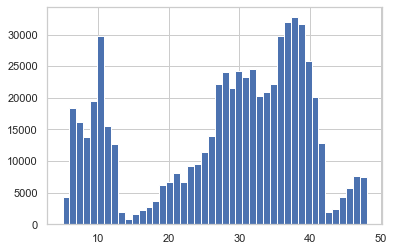

In [120]:
data.od_origin_week.hist(bins=44)

origin_current_school_holiday
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: od_origin_week, dtype: object

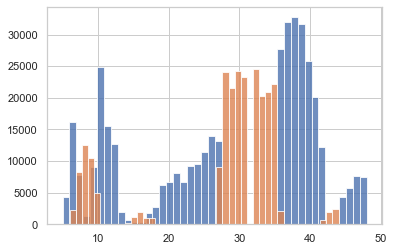

In [121]:
data.groupby("origin_current_school_holiday").od_origin_week.hist(bins=44, alpha=0.8)

origin_current_public_holiday
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: od_origin_week, dtype: object

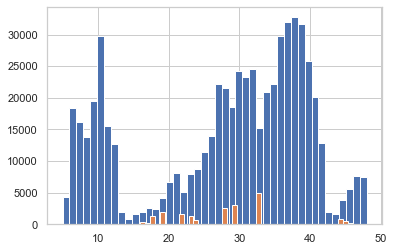

In [122]:
data.groupby("origin_current_public_holiday").od_origin_week.hist(bins=44)

origin_current_school_holiday
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: trip_or_dest, dtype: object

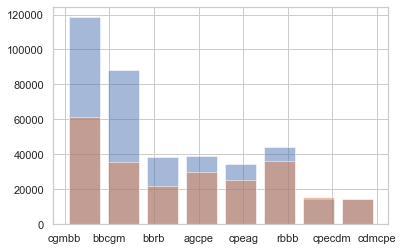

In [130]:
data.groupby("origin_current_school_holiday").trip_or_dest.hist(bins=8,rwidth=0.8,alpha=0.5)

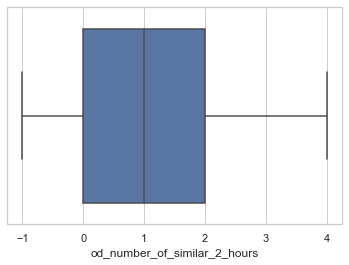

In [87]:
ax=sns.boxplot(x=data["od_number_of_similar_2_hours"])

### Missing value :

Removal of missing values (-1):

In [88]:
data.od_number_of_similar_2_hours.describe()

count    632841.00000
mean          1.42268
std           1.35439
min          -1.00000
25%           0.00000
50%           1.00000
75%           2.00000
max           4.00000
Name: od_number_of_similar_2_hours, dtype: float64

In [94]:
data.loc[(data['od_number_of_similar_2_hours']<0)]

,dataset_type,demand,departure_date,destination_current_public_holiday,destination_current_school_holiday,destination_days_to_next_public_holiday,destination_days_to_next_school_holiday,destination_station_name,od_destination_time,od_number_of_similar_12_hours,...,sale_date,sale_day,sale_day_x,sale_month,sale_week,sale_weekday,sale_year,trip_id,trip_or_dest,tripday_idt


In [96]:
data.loc[(data['od_number_of_similar_12_hours']<0)]

,dataset_type,demand,departure_date,destination_current_public_holiday,destination_current_school_holiday,destination_days_to_next_public_holiday,destination_days_to_next_school_holiday,destination_station_name,od_destination_time,od_number_of_similar_12_hours,...,sale_date,sale_day,sale_day_x,sale_month,sale_week,sale_weekday,sale_year,trip_id,trip_or_dest,tripday_idt


In [93]:
data = data.drop(data[data.od_number_of_similar_2_hours < 0].index)

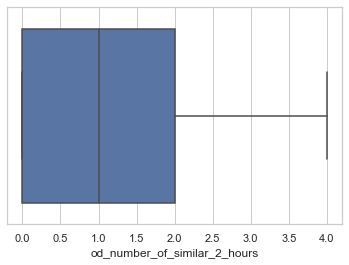

In [97]:
ax=sns.boxplot(x=data["od_number_of_similar_2_hours"])

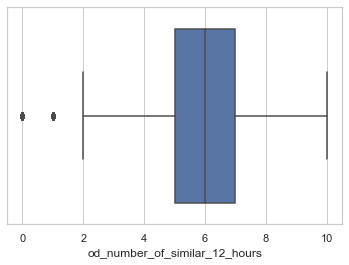

In [98]:
ax=sns.boxplot(x=data["od_number_of_similar_12_hours"])

## Correction of the Sale_week column

The *sale_week* column is false and corresponds to the *sale_weekday* column.

In [50]:
sale_week= [
            datetime.date(year, month, day).isocalendar()[1]
            for year,month, day in zip(
                data.sale_year,data.sale_month, data.sale_day
            )
        ]

In [52]:
data["sale_week"]=sale_week

## Creation of new columns

Creation of an id for each train from the date, time, origin and destination

In [54]:
trip_id= [f"{datetime}{time}{start}{end}"
          for datetime,time, start, end in zip(
              data.departure_date,data.od_origin_time, data.origin_station_name, data.destination_station_name
            )
        ]

In [55]:
tripday_id= [f"{datetime}{start}{end}"
             for datetime, start, end in zip(
                 data.departure_date, data.origin_station_name, data.destination_station_name
             )
        ]

Creation of a variable describing the train journey (origin to destination)

In [56]:
trip_or_dest= [ f"{start}{end}"
               for start, end in zip(
                   data.origin_station_name, data.destination_station_name
               )
        ]

In [9]:
data=data.assign(trip_id=lambda data:trip_id)

In [10]:
data=data.assign(trip_or_dest=lambda data:trip_or_dest)

In [11]:
data=data.assign(tripday_idt=lambda data:tripday_id)

In [52]:
data.trip_or_dest.describe()

count     632841
unique         8
top        cgmbb
freq      179872
Name: trip_or_dest, dtype: object